# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*

## Loading data

In [98]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ac      1206 non-null   int64 
 1   con     1206 non-null   int64 
 2   book    1206 non-null   object
 3   dex     1206 non-null   int64 
 4   hp      1206 non-null   int64 
 5   cha     1206 non-null   int64 
 6   level   1206 non-null   int64 
 7   str     1206 non-null   int64 
 8   int     1206 non-null   int64 
 9   wis     1206 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 103.6+ KB


In [100]:
df.head()

,ac,con,book,dex,hp,cha,level,str,int,wis
0,29,5,Pathfinder Bestiary,2,215,1,10,7,1,2
1,28,5,Pathfinder Bestiary,0,220,1,10,9,-4,2
2,25,6,Pathfinder Bestiary,3,175,-2,8,7,-4,3
3,41,5,Pathfinder Bestiary,4,315,6,17,7,6,5
4,16,1,Pathfinder Bestiary,3,20,1,1,-5,-1,1


###### Level

In [101]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [102]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [103]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


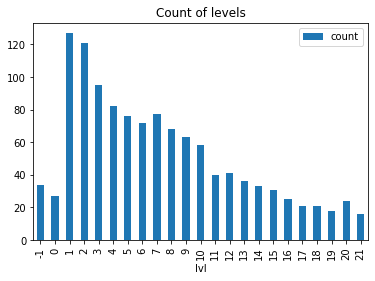

In [104]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [105]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [106]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [107]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [108]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [109]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 8
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [110]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [111]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.45
RMSE: 0.67
MAE: 0.47


In [112]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "normal", len(X_test.columns), mse, rmse, mae]

In [113]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.31
RMSE test: 0.67


###### MAE by level

In [114]:
from training.results import plot_mae_by_level

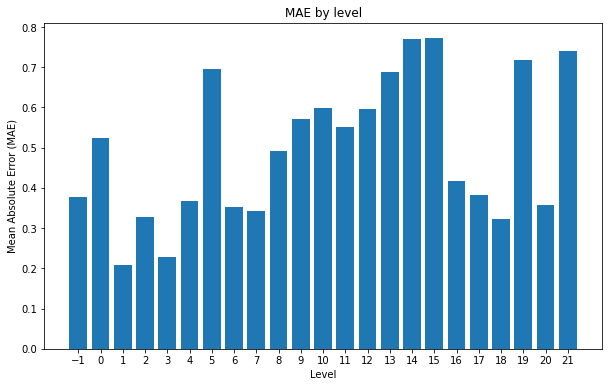

In [115]:
plot_mae_by_level(y_test, y_pred_test)

In [116]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 0.45
RMSE: 0.67

Round type: round
MSE: 0.50
RMSE: 0.71

Round type: 0.33
MSE: 0.50
RMSE: 0.71

Round type: 0.45
MSE: 0.48
RMSE: 0.70



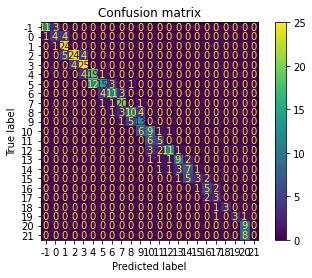

In [117]:
plot_confusion_matrix("round", y_pred_test, y_test)

#### Tuning

In [118]:
from training.results import assess_regression_model

In [119]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-04 13:49:45,379] A new study created in memory with name: no-name-1b30da29-8db5-45c0-a6c7-3e6da43ec25e
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.230632 + 0.0307953
[200]	cv_agg's l2: 0.22273 + 0.0331115
[300]	cv_agg's l2: 0.221132 + 0.0345973


feature_fraction, val_score: 0.220372:   0%|                                                     | 0/7 [00:01<?, ?it/s]

[400]	cv_agg's l2: 0.220698 + 0.0351435
Early stopping, best iteration is:
[355]	cv_agg's l2: 0.220372 + 0.034704


feature_fraction, val_score: 0.220372:  14%|######4                                      | 1/7 [00:01<00:10,  1.75s/it]

[100]	cv_agg's l2: 0.230956 + 0.0449724
[200]	cv_agg's l2: 0.22657 + 0.0421082
[300]	cv_agg's l2: 0.227534 + 0.0415727


feature_fraction, val_score: 0.220372:  29%|############8                                | 2/7 [00:03<00:08,  1.70s/it]

[400]	cv_agg's l2: 0.228548 + 0.0429126
Early stopping, best iteration is:
[355]	cv_agg's l2: 0.220372 + 0.034704
[100]	cv_agg's l2: 0.234102 + 0.0514901
[200]	cv_agg's l2: 0.232555 + 0.0495999
[300]	cv_agg's l2: 0.234555 + 0.0509719


feature_fraction, val_score: 0.220372:  29%|############8                                | 2/7 [00:04<00:08,  1.70s/it]

[400]	cv_agg's l2: 0.238087 + 0.0528755
Early stopping, best iteration is:
[355]	cv_agg's l2: 0.220372 + 0.034704


feature_fraction, val_score: 0.220372:  43%|###################2                         | 3/7 [00:04<00:06,  1.62s/it]

[100]	cv_agg's l2: 0.239717 + 0.0306885
[200]	cv_agg's l2: 0.226874 + 0.0336493
[300]	cv_agg's l2: 0.225727 + 0.0345733


feature_fraction, val_score: 0.220372:  57%|#########################7                   | 4/7 [00:06<00:04,  1.61s/it][I 2023-11-04 13:49:51,911] Trial 3 finished with value: 0.22578457607405253 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.22037228118977334.


[400]	cv_agg's l2: 0.22627 + 0.0364027
Early stopping, best iteration is:
[355]	cv_agg's l2: 0.220372 + 0.034704


feature_fraction, val_score: 0.220372:  57%|#########################7                   | 4/7 [00:06<00:04,  1.61s/it]

[100]	cv_agg's l2: 0.230632 + 0.0307953
[200]	cv_agg's l2: 0.22273 + 0.0331115
[300]	cv_agg's l2: 0.221132 + 0.0345973


feature_fraction, val_score: 0.220372:  71%|################################1            | 5/7 [00:07<00:02,  1.50s/it]

[400]	cv_agg's l2: 0.220698 + 0.0351435
Early stopping, best iteration is:
[355]	cv_agg's l2: 0.220372 + 0.034704
[100]	cv_agg's l2: 0.312587 + 0.0674292
[200]	cv_agg's l2: 0.275573 + 0.0601152
[300]	cv_agg's l2: 0.262959 + 0.057129


feature_fraction, val_score: 0.220372:  86%|######################################5      | 6/7 [00:09<00:01,  1.41s/it]

[400]	cv_agg's l2: 0.255333 + 0.0542105
Early stopping, best iteration is:
[355]	cv_agg's l2: 0.220372 + 0.034704
[100]	cv_agg's l2: 0.291343 + 0.0614798
[200]	cv_agg's l2: 0.261769 + 0.0592493
[300]	cv_agg's l2: 0.254003 + 0.0576832


feature_fraction, val_score: 0.220372: 100%|#############################################| 7/7 [00:10<00:00,  1.50s/it]


[400]	cv_agg's l2: 0.251613 + 0.0560866
Early stopping, best iteration is:
[355]	cv_agg's l2: 0.220372 + 0.034704


num_leaves, val_score: 0.220372:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.230632 + 0.0307953
[200]	cv_agg's l2: 0.22273 + 0.0331115
[300]	cv_agg's l2: 0.221132 + 0.0345973


num_leaves, val_score: 0.220372:   0%|                                                          | 0/20 [00:01<?, ?it/s]

[400]	cv_agg's l2: 0.220698 + 0.0351435
Early stopping, best iteration is:
[355]	cv_agg's l2: 0.220372 + 0.034704


num_leaves, val_score: 0.220372:   5%|##5                                               | 1/20 [00:01<00:31,  1.66s/it]

[100]	cv_agg's l2: 0.230632 + 0.0307953
[200]	cv_agg's l2: 0.22273 + 0.0331115
[300]	cv_agg's l2: 0.221132 + 0.0345973


num_leaves, val_score: 0.220372:  10%|#####                                             | 2/20 [00:03<00:27,  1.55s/it]

[400]	cv_agg's l2: 0.220698 + 0.0351435
Early stopping, best iteration is:
[355]	cv_agg's l2: 0.220372 + 0.034704


[I 2023-11-04 13:49:59,006] Trial 8 finished with value: 0.22037228118977334 and parameters: {'num_leaves': 207}. Best is trial 7 with value: 0.22037228118977334.
num_leaves, val_score: 0.220372:  10%|#####                                             | 2/20 [00:03<00:27,  1.55s/it]

[100]	cv_agg's l2: 0.230632 + 0.0307953
[200]	cv_agg's l2: 0.22273 + 0.0331115
[300]	cv_agg's l2: 0.221132 + 0.0345973


num_leaves, val_score: 0.220372:  15%|#######5                                          | 3/20 [00:04<00:25,  1.50s/it]

[400]	cv_agg's l2: 0.220698 + 0.0351435
Early stopping, best iteration is:
[355]	cv_agg's l2: 0.220372 + 0.034704


[I 2023-11-04 13:50:00,444] Trial 9 finished with value: 0.22037228118977334 and parameters: {'num_leaves': 158}. Best is trial 7 with value: 0.22037228118977334.
num_leaves, val_score: 0.220372:  15%|#######5                                          | 3/20 [00:04<00:25,  1.50s/it]

[100]	cv_agg's l2: 0.336303 + 0.0425351
[200]	cv_agg's l2: 0.311839 + 0.0426278
[300]	cv_agg's l2: 0.305977 + 0.0432176


num_leaves, val_score: 0.220372:  20%|##########                                        | 4/20 [00:04<00:16,  1.04s/it]

[400]	cv_agg's l2: 0.302326 + 0.0438819
Early stopping, best iteration is:
[355]	cv_agg's l2: 0.220372 + 0.034704
[100]	cv_agg's l2: 0.230632 + 0.0307953
[200]	cv_agg's l2: 0.22273 + 0.0331115
[300]	cv_agg's l2: 0.221132 + 0.0345973


num_leaves, val_score: 0.220372:  25%|############5                                     | 5/20 [00:06<00:17,  1.14s/it]

[400]	cv_agg's l2: 0.220698 + 0.0351435
Early stopping, best iteration is:
[355]	cv_agg's l2: 0.220372 + 0.034704
[100]	cv_agg's l2: 0.230632 + 0.0307953
[200]	cv_agg's l2: 0.22273 + 0.0331115
[300]	cv_agg's l2: 0.221132 + 0.0345973


num_leaves, val_score: 0.220372:  25%|############5                                     | 5/20 [00:07<00:17,  1.14s/it]

[400]	cv_agg's l2: 0.220698 + 0.0351435
Early stopping, best iteration is:
[355]	cv_agg's l2: 0.220372 + 0.034704


num_leaves, val_score: 0.220372:  30%|###############                                   | 6/20 [00:07<00:17,  1.25s/it]

[100]	cv_agg's l2: 0.230632 + 0.0307953
[200]	cv_agg's l2: 0.22273 + 0.0331115
[300]	cv_agg's l2: 0.221132 + 0.0345973


num_leaves, val_score: 0.220372:  35%|#################5                                | 7/20 [00:09<00:16,  1.30s/it]

[400]	cv_agg's l2: 0.220698 + 0.0351435
Early stopping, best iteration is:
[355]	cv_agg's l2: 0.220372 + 0.034704
[100]	cv_agg's l2: 0.230632 + 0.0307953
[200]	cv_agg's l2: 0.22273 + 0.0331115
[300]	cv_agg's l2: 0.221132 + 0.0345973


num_leaves, val_score: 0.220372:  35%|#################5                                | 7/20 [00:10<00:16,  1.30s/it]

[400]	cv_agg's l2: 0.220698 + 0.0351435
Early stopping, best iteration is:
[355]	cv_agg's l2: 0.220372 + 0.034704


num_leaves, val_score: 0.220372:  40%|####################                              | 8/20 [00:10<00:15,  1.32s/it]

[100]	cv_agg's l2: 0.230632 + 0.0307953
[200]	cv_agg's l2: 0.22273 + 0.0331115
[300]	cv_agg's l2: 0.221132 + 0.0345973


num_leaves, val_score: 0.220372:  45%|######################5                           | 9/20 [00:11<00:15,  1.37s/it]

[400]	cv_agg's l2: 0.220698 + 0.0351435
Early stopping, best iteration is:
[355]	cv_agg's l2: 0.220372 + 0.034704


[I 2023-11-04 13:50:07,820] Trial 15 finished with value: 0.22037228118977334 and parameters: {'num_leaves': 245}. Best is trial 7 with value: 0.22037228118977334.
num_leaves, val_score: 0.220372:  45%|######################5                           | 9/20 [00:11<00:15,  1.37s/it]

[100]	cv_agg's l2: 0.249141 + 0.0372879
[200]	cv_agg's l2: 0.231544 + 0.0367404
[300]	cv_agg's l2: 0.225124 + 0.0336463
[400]	cv_agg's l2: 0.220919 + 0.0316425
[500]	cv_agg's l2: 0.218768 + 0.0318685
[600]	cv_agg's l2: 0.216763 + 0.0310282
[700]	cv_agg's l2: 0.216242 + 0.0322861
[800]	cv_agg's l2: 0.215332 + 0.0326991


num_leaves, val_score: 0.214273:  45%|######################5                           | 9/20 [00:13<00:15,  1.37s/it]

[900]	cv_agg's l2: 0.214976 + 0.0333215
[1000]	cv_agg's l2: 0.214689 + 0.0340629
Early stopping, best iteration is:
[947]	cv_agg's l2: 0.214273 + 0.0333399


num_leaves, val_score: 0.214273:  50%|########################5                        | 10/20 [00:13<00:13,  1.36s/it]

[100]	cv_agg's l2: 0.249141 + 0.0372879
[200]	cv_agg's l2: 0.231544 + 0.0367404
[300]	cv_agg's l2: 0.225124 + 0.0336463
[400]	cv_agg's l2: 0.220919 + 0.0316425
[500]	cv_agg's l2: 0.218768 + 0.0318685
[600]	cv_agg's l2: 0.216763 + 0.0310282
[700]	cv_agg's l2: 0.216242 + 0.0322861
[800]	cv_agg's l2: 0.215332 + 0.0326991


num_leaves, val_score: 0.214273:  50%|########################5                        | 10/20 [00:14<00:13,  1.36s/it]

[900]	cv_agg's l2: 0.214976 + 0.0333215
[1000]	cv_agg's l2: 0.214689 + 0.0340629
Early stopping, best iteration is:
[947]	cv_agg's l2: 0.214273 + 0.0333399


num_leaves, val_score: 0.214273:  55%|##########################9                      | 11/20 [00:14<00:12,  1.35s/it]

[100]	cv_agg's l2: 0.336303 + 0.0425351
[200]	cv_agg's l2: 0.311839 + 0.0426278
[300]	cv_agg's l2: 0.305977 + 0.0432176
[400]	cv_agg's l2: 0.302326 + 0.0438819
[500]	cv_agg's l2: 0.300118 + 0.044869
[600]	cv_agg's l2: 0.298124 + 0.045867
[700]	cv_agg's l2: 0.296618 + 0.0468542
[800]	cv_agg's l2: 0.295229 + 0.0475398


num_leaves, val_score: 0.214273:  60%|#############################4                   | 12/20 [00:15<00:09,  1.16s/it]

[900]	cv_agg's l2: 0.293989 + 0.0478714
[1000]	cv_agg's l2: 0.293142 + 0.0481623
Early stopping, best iteration is:
[947]	cv_agg's l2: 0.214273 + 0.0333399
[100]	cv_agg's l2: 0.230632 + 0.0307953
[200]	cv_agg's l2: 0.22273 + 0.0331115
[300]	cv_agg's l2: 0.221132 + 0.0345973
[400]	cv_agg's l2: 0.220698 + 0.0351435
[500]	cv_agg's l2: 0.222758 + 0.0367502
[600]	cv_agg's l2: 0.224022 + 0.0369605
[700]	cv_agg's l2: 0.225437 + 0.0375943
[800]	cv_agg's l2: 0.227167 + 0.037435
[900]	cv_agg's l2: 0.228293 + 0.037477


num_leaves, val_score: 0.214273:  65%|###############################8                 | 13/20 [00:18<00:12,  1.83s/it]

[1000]	cv_agg's l2: 0.229444 + 0.0376357
Early stopping, best iteration is:
[947]	cv_agg's l2: 0.214273 + 0.0333399
[100]	cv_agg's l2: 0.230632 + 0.0307953
[200]	cv_agg's l2: 0.22273 + 0.0331115
[300]	cv_agg's l2: 0.221132 + 0.0345973
[400]	cv_agg's l2: 0.220698 + 0.0351435
[500]	cv_agg's l2: 0.222758 + 0.0367502
[600]	cv_agg's l2: 0.224022 + 0.0369605
[700]	cv_agg's l2: 0.225437 + 0.0375943
[800]	cv_agg's l2: 0.227167 + 0.037435
[900]	cv_agg's l2: 0.228293 + 0.037477


num_leaves, val_score: 0.214273:  70%|##################################3              | 14/20 [00:21<00:13,  2.20s/it]

[1000]	cv_agg's l2: 0.229444 + 0.0376357
Early stopping, best iteration is:
[947]	cv_agg's l2: 0.214273 + 0.0333399
[100]	cv_agg's l2: 0.230632 + 0.0307953
[200]	cv_agg's l2: 0.22273 + 0.0331115
[300]	cv_agg's l2: 0.221132 + 0.0345973
[400]	cv_agg's l2: 0.220698 + 0.0351435
[500]	cv_agg's l2: 0.222758 + 0.0367502
[600]	cv_agg's l2: 0.224022 + 0.0369605
[700]	cv_agg's l2: 0.225437 + 0.0375943
[800]	cv_agg's l2: 0.227167 + 0.037435
[900]	cv_agg's l2: 0.228293 + 0.037477


num_leaves, val_score: 0.214273:  75%|####################################7            | 15/20 [00:25<00:12,  2.53s/it]

[1000]	cv_agg's l2: 0.229444 + 0.0376357
Early stopping, best iteration is:
[947]	cv_agg's l2: 0.214273 + 0.0333399
[100]	cv_agg's l2: 0.234663 + 0.0307537
[200]	cv_agg's l2: 0.227713 + 0.0338084
[300]	cv_agg's l2: 0.227836 + 0.0357337
[400]	cv_agg's l2: 0.227977 + 0.0362373
[500]	cv_agg's l2: 0.229033 + 0.0364221
[600]	cv_agg's l2: 0.2304 + 0.0371448
[700]	cv_agg's l2: 0.231314 + 0.0371379
[800]	cv_agg's l2: 0.23246 + 0.0372517
[900]	cv_agg's l2: 0.233593 + 0.0373084


num_leaves, val_score: 0.214273:  80%|#######################################2         | 16/20 [00:28<00:11,  2.80s/it]

[1000]	cv_agg's l2: 0.234744 + 0.037141
Early stopping, best iteration is:
[947]	cv_agg's l2: 0.214273 + 0.0333399
[100]	cv_agg's l2: 0.230632 + 0.0307953
[200]	cv_agg's l2: 0.22273 + 0.0331115
[300]	cv_agg's l2: 0.221132 + 0.0345973
[400]	cv_agg's l2: 0.220698 + 0.0351435
[500]	cv_agg's l2: 0.222758 + 0.0367502
[600]	cv_agg's l2: 0.224022 + 0.0369605
[700]	cv_agg's l2: 0.225437 + 0.0375943
[800]	cv_agg's l2: 0.227167 + 0.037435
[900]	cv_agg's l2: 0.228293 + 0.037477


num_leaves, val_score: 0.214273:  85%|#########################################6       | 17/20 [00:31<00:09,  3.01s/it]

[1000]	cv_agg's l2: 0.229444 + 0.0376357
Early stopping, best iteration is:
[947]	cv_agg's l2: 0.214273 + 0.0333399
[100]	cv_agg's l2: 0.230632 + 0.0307953
[200]	cv_agg's l2: 0.22273 + 0.0331115
[300]	cv_agg's l2: 0.221132 + 0.0345973
[400]	cv_agg's l2: 0.220698 + 0.0351435
[500]	cv_agg's l2: 0.222758 + 0.0367502
[600]	cv_agg's l2: 0.224022 + 0.0369605
[700]	cv_agg's l2: 0.225437 + 0.0375943
[800]	cv_agg's l2: 0.227167 + 0.037435
[900]	cv_agg's l2: 0.228293 + 0.037477


num_leaves, val_score: 0.214273:  85%|#########################################6       | 17/20 [00:35<00:09,  3.01s/it]

[1000]	cv_agg's l2: 0.229444 + 0.0376357
Early stopping, best iteration is:
[947]	cv_agg's l2: 0.214273 + 0.0333399


num_leaves, val_score: 0.214273:  90%|############################################1    | 18/20 [00:35<00:06,  3.08s/it]

[100]	cv_agg's l2: 0.230632 + 0.0307953
[200]	cv_agg's l2: 0.22273 + 0.0331115
[300]	cv_agg's l2: 0.221132 + 0.0345973
[400]	cv_agg's l2: 0.220698 + 0.0351435
[500]	cv_agg's l2: 0.222758 + 0.0367502
[600]	cv_agg's l2: 0.224022 + 0.0369605
[700]	cv_agg's l2: 0.225437 + 0.0375943
[800]	cv_agg's l2: 0.227167 + 0.037435
[900]	cv_agg's l2: 0.228293 + 0.037477


num_leaves, val_score: 0.214273:  90%|############################################1    | 18/20 [00:38<00:06,  3.08s/it]

[1000]	cv_agg's l2: 0.229444 + 0.0376357
Early stopping, best iteration is:
[947]	cv_agg's l2: 0.214273 + 0.0333399


num_leaves, val_score: 0.214273:  95%|##############################################5  | 19/20 [00:38<00:03,  3.18s/it]

[100]	cv_agg's l2: 0.230437 + 0.030904
[200]	cv_agg's l2: 0.221579 + 0.0330663
[300]	cv_agg's l2: 0.220222 + 0.0339768
[400]	cv_agg's l2: 0.219644 + 0.0345032
[500]	cv_agg's l2: 0.22042 + 0.0349207
[600]	cv_agg's l2: 0.221815 + 0.0353529
[700]	cv_agg's l2: 0.222918 + 0.0354182
[800]	cv_agg's l2: 0.224164 + 0.035327
[900]	cv_agg's l2: 0.225542 + 0.0353189


num_leaves, val_score: 0.214273: 100%|#################################################| 20/20 [00:42<00:00,  2.11s/it]


[1000]	cv_agg's l2: 0.226479 + 0.0354548
Early stopping, best iteration is:
[947]	cv_agg's l2: 0.214273 + 0.0333399


bagging, val_score: 0.214273:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.276228 + 0.0379155
[200]	cv_agg's l2: 0.254238 + 0.042008
[300]	cv_agg's l2: 0.247603 + 0.0406541
[400]	cv_agg's l2: 0.240028 + 0.0395953
[500]	cv_agg's l2: 0.235667 + 0.0371021
[600]	cv_agg's l2: 0.233279 + 0.0403393
[700]	cv_agg's l2: 0.232331 + 0.0419137
[800]	cv_agg's l2: 0.229292 + 0.0384574
[900]	cv_agg's l2: 0.22757 + 0.0381468
[1000]	cv_agg's l2: 0.228274 + 0.0348647


bagging, val_score: 0.214273:  10%|#####3                                               | 1/10 [00:01<00:15,  1.73s/it]

Early stopping, best iteration is:
[947]	cv_agg's l2: 0.214273 + 0.0333399
[100]	cv_agg's l2: 0.247825 + 0.0312618
[200]	cv_agg's l2: 0.233428 + 0.0321328
[300]	cv_agg's l2: 0.224898 + 0.031784
[400]	cv_agg's l2: 0.220059 + 0.030129
[500]	cv_agg's l2: 0.217817 + 0.0312127
[600]	cv_agg's l2: 0.216168 + 0.0302874
[700]	cv_agg's l2: 0.215532 + 0.0301114
[800]	cv_agg's l2: 0.21469 + 0.0309331
[900]	cv_agg's l2: 0.213321 + 0.0316521
[1000]	cv_agg's l2: 0.213329 + 0.0319333


bagging, val_score: 0.212961:  20%|##########6                                          | 2/10 [00:03<00:14,  1.78s/it]

Early stopping, best iteration is:
[957]	cv_agg's l2: 0.212961 + 0.0321251
[100]	cv_agg's l2: 0.244607 + 0.0351567
[200]	cv_agg's l2: 0.228876 + 0.0335062
[300]	cv_agg's l2: 0.221174 + 0.0330546
[400]	cv_agg's l2: 0.216651 + 0.0316476
[500]	cv_agg's l2: 0.212773 + 0.0319381
[600]	cv_agg's l2: 0.211041 + 0.0320934
[700]	cv_agg's l2: 0.210619 + 0.0326311
[800]	cv_agg's l2: 0.210028 + 0.0329411
[900]	cv_agg's l2: 0.20989 + 0.0333379
[1000]	cv_agg's l2: 0.209856 + 0.0334489


bagging, val_score: 0.209348:  30%|###############9                                     | 3/10 [00:05<00:13,  1.94s/it]

Early stopping, best iteration is:
[919]	cv_agg's l2: 0.209348 + 0.0333103
[100]	cv_agg's l2: 0.24615 + 0.0355671
[200]	cv_agg's l2: 0.232228 + 0.0361586
[300]	cv_agg's l2: 0.225507 + 0.0340973
[400]	cv_agg's l2: 0.220498 + 0.0338103
[500]	cv_agg's l2: 0.217931 + 0.0328783
[600]	cv_agg's l2: 0.215913 + 0.0324899
[700]	cv_agg's l2: 0.214589 + 0.0338296
[800]	cv_agg's l2: 0.214156 + 0.0341834
[900]	cv_agg's l2: 0.213993 + 0.0338688


bagging, val_score: 0.209348:  40%|#####################2                               | 4/10 [00:07<00:11,  1.99s/it]

[1000]	cv_agg's l2: 0.213691 + 0.0329444
Early stopping, best iteration is:
[919]	cv_agg's l2: 0.209348 + 0.0333103
[100]	cv_agg's l2: 0.245118 + 0.0342939
[200]	cv_agg's l2: 0.229738 + 0.032756
[300]	cv_agg's l2: 0.221256 + 0.0322054
[400]	cv_agg's l2: 0.217734 + 0.0313962
[500]	cv_agg's l2: 0.214811 + 0.0310305
[600]	cv_agg's l2: 0.213068 + 0.03073
[700]	cv_agg's l2: 0.211885 + 0.0304965
[800]	cv_agg's l2: 0.210768 + 0.0304506
[900]	cv_agg's l2: 0.210209 + 0.030906
[1000]	cv_agg's l2: 0.210028 + 0.0315537


bagging, val_score: 0.209348:  50%|##########################5                          | 5/10 [00:09<00:09,  1.99s/it]

Early stopping, best iteration is:
[919]	cv_agg's l2: 0.209348 + 0.0333103
[100]	cv_agg's l2: 0.249324 + 0.0355253
[200]	cv_agg's l2: 0.233807 + 0.0348817
[300]	cv_agg's l2: 0.227269 + 0.0328492
[400]	cv_agg's l2: 0.223304 + 0.0329434
[500]	cv_agg's l2: 0.219147 + 0.0318009
[600]	cv_agg's l2: 0.217201 + 0.0317656
[700]	cv_agg's l2: 0.215307 + 0.031209
[800]	cv_agg's l2: 0.214278 + 0.03163


bagging, val_score: 0.209348:  50%|##########################5                          | 5/10 [00:11<00:09,  1.99s/it]

[900]	cv_agg's l2: 0.214271 + 0.0316293
[1000]	cv_agg's l2: 0.213415 + 0.0317648
Early stopping, best iteration is:
[919]	cv_agg's l2: 0.209348 + 0.0333103


bagging, val_score: 0.209348:  60%|###############################8                     | 6/10 [00:11<00:07,  1.97s/it]

[100]	cv_agg's l2: 0.25175 + 0.0342381
[200]	cv_agg's l2: 0.235792 + 0.0361094
[300]	cv_agg's l2: 0.225917 + 0.0323206
[400]	cv_agg's l2: 0.221888 + 0.0307556
[500]	cv_agg's l2: 0.219325 + 0.0314739
[600]	cv_agg's l2: 0.21733 + 0.0328098
[700]	cv_agg's l2: 0.217154 + 0.0327134
[800]	cv_agg's l2: 0.215762 + 0.032952
[900]	cv_agg's l2: 0.214824 + 0.0338774


bagging, val_score: 0.209348:  70%|#####################################                | 7/10 [00:14<00:06,  2.30s/it]

[1000]	cv_agg's l2: 0.214895 + 0.0346131
Early stopping, best iteration is:
[919]	cv_agg's l2: 0.209348 + 0.0333103
[100]	cv_agg's l2: 0.244579 + 0.0330817
[200]	cv_agg's l2: 0.229396 + 0.0328908
[300]	cv_agg's l2: 0.221877 + 0.0315525
[400]	cv_agg's l2: 0.219422 + 0.029621
[500]	cv_agg's l2: 0.216237 + 0.0293223
[600]	cv_agg's l2: 0.2143 + 0.0290865
[700]	cv_agg's l2: 0.213431 + 0.0292974
[800]	cv_agg's l2: 0.211178 + 0.0289793
[900]	cv_agg's l2: 0.21025 + 0.0297129


bagging, val_score: 0.209348:  80%|##########################################4          | 8/10 [00:18<00:05,  2.67s/it]

[1000]	cv_agg's l2: 0.210399 + 0.0299178
Early stopping, best iteration is:
[919]	cv_agg's l2: 0.209348 + 0.0333103
[100]	cv_agg's l2: 0.249049 + 0.0401087
[200]	cv_agg's l2: 0.230977 + 0.0378684
[300]	cv_agg's l2: 0.222094 + 0.0342754
[400]	cv_agg's l2: 0.216431 + 0.0322461
[500]	cv_agg's l2: 0.213211 + 0.0305796
[600]	cv_agg's l2: 0.210592 + 0.0299387
[700]	cv_agg's l2: 0.209347 + 0.0295826
[800]	cv_agg's l2: 0.208242 + 0.0304293
[900]	cv_agg's l2: 0.208256 + 0.0302545
[1000]	cv_agg's l2: 0.207485 + 0.0305259
[1100]	cv_agg's l2: 0.207213 + 0.0297283
[1200]	cv_agg's l2: 0.206443 + 0.0300166


bagging, val_score: 0.206301:  90%|###############################################7     | 9/10 [00:22<00:03,  3.33s/it]

[1300]	cv_agg's l2: 0.207348 + 0.029517
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.258467 + 0.0375139
[200]	cv_agg's l2: 0.24333 + 0.032342
[300]	cv_agg's l2: 0.233281 + 0.034432
[400]	cv_agg's l2: 0.231473 + 0.0329987
[500]	cv_agg's l2: 0.225754 + 0.0303411
[600]	cv_agg's l2: 0.223826 + 0.029612
[700]	cv_agg's l2: 0.220867 + 0.0284423
[800]	cv_agg's l2: 0.221044 + 0.0297711
[900]	cv_agg's l2: 0.219515 + 0.0287114
[1000]	cv_agg's l2: 0.219089 + 0.0280344
[1100]	cv_agg's l2: 0.218161 + 0.0281914
[1200]	cv_agg's l2: 0.218452 + 0.0282428


bagging, val_score: 0.206301: 100%|####################################################| 10/10 [00:27<00:00,  2.74s/it]


[1300]	cv_agg's l2: 0.217166 + 0.0283699
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652


feature_fraction_stage2, val_score: 0.206301:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.254022 + 0.0391858
[200]	cv_agg's l2: 0.231613 + 0.0372056
[300]	cv_agg's l2: 0.22267 + 0.0354093
[400]	cv_agg's l2: 0.216897 + 0.035819
[500]	cv_agg's l2: 0.214627 + 0.0354139
[600]	cv_agg's l2: 0.212891 + 0.0346041
[700]	cv_agg's l2: 0.211521 + 0.0353253
[800]	cv_agg's l2: 0.211973 + 0.0351917
[900]	cv_agg's l2: 0.210198 + 0.0345823
[1000]	cv_agg's l2: 0.209725 + 0.0346586
[1100]	cv_agg's l2: 0.209905 + 0.0341785
[1200]	cv_agg's l2: 0.209988 + 0.0351772


feature_fraction_stage2, val_score: 0.206301:  17%|######3                               | 1/6 [00:04<00:21,  4.34s/it]

[1300]	cv_agg's l2: 0.210228 + 0.0351046
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.254022 + 0.0391858
[200]	cv_agg's l2: 0.231613 + 0.0372056
[300]	cv_agg's l2: 0.22267 + 0.0354093
[400]	cv_agg's l2: 0.216897 + 0.035819
[500]	cv_agg's l2: 0.214627 + 0.0354139
[600]	cv_agg's l2: 0.212891 + 0.0346041
[700]	cv_agg's l2: 0.211521 + 0.0353253
[800]	cv_agg's l2: 0.211973 + 0.0351917
[900]	cv_agg's l2: 0.210198 + 0.0345823
[1000]	cv_agg's l2: 0.209725 + 0.0346586
[1100]	cv_agg's l2: 0.209905 + 0.0341785
[1200]	cv_agg's l2: 0.209988 + 0.0351772


feature_fraction_stage2, val_score: 0.206301:  33%|############6                         | 2/6 [00:08<00:17,  4.45s/it]

[1300]	cv_agg's l2: 0.210228 + 0.0351046
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.249049 + 0.0401087
[200]	cv_agg's l2: 0.230977 + 0.0378684
[300]	cv_agg's l2: 0.222094 + 0.0342754
[400]	cv_agg's l2: 0.216431 + 0.0322461
[500]	cv_agg's l2: 0.213211 + 0.0305796
[600]	cv_agg's l2: 0.210592 + 0.0299387
[700]	cv_agg's l2: 0.209347 + 0.0295826
[800]	cv_agg's l2: 0.208242 + 0.0304293
[900]	cv_agg's l2: 0.208256 + 0.0302545
[1000]	cv_agg's l2: 0.207485 + 0.0305259
[1100]	cv_agg's l2: 0.207213 + 0.0297283
[1200]	cv_agg's l2: 0.206443 + 0.0300166


feature_fraction_stage2, val_score: 0.206301:  50%|###################                   | 3/6 [00:13<00:13,  4.49s/it]

[1300]	cv_agg's l2: 0.207348 + 0.029517
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.254022 + 0.0391858
[200]	cv_agg's l2: 0.231613 + 0.0372056
[300]	cv_agg's l2: 0.22267 + 0.0354093
[400]	cv_agg's l2: 0.216897 + 0.035819
[500]	cv_agg's l2: 0.214627 + 0.0354139
[600]	cv_agg's l2: 0.212891 + 0.0346041
[700]	cv_agg's l2: 0.211521 + 0.0353253
[800]	cv_agg's l2: 0.211973 + 0.0351917
[900]	cv_agg's l2: 0.210198 + 0.0345823
[1000]	cv_agg's l2: 0.209725 + 0.0346586
[1100]	cv_agg's l2: 0.209905 + 0.0341785
[1200]	cv_agg's l2: 0.209988 + 0.0351772


feature_fraction_stage2, val_score: 0.206301:  67%|#########################3            | 4/6 [00:17<00:08,  4.49s/it]

[1300]	cv_agg's l2: 0.210228 + 0.0351046
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.249049 + 0.0401087
[200]	cv_agg's l2: 0.230977 + 0.0378684
[300]	cv_agg's l2: 0.222094 + 0.0342754
[400]	cv_agg's l2: 0.216431 + 0.0322461
[500]	cv_agg's l2: 0.213211 + 0.0305796
[600]	cv_agg's l2: 0.210592 + 0.0299387
[700]	cv_agg's l2: 0.209347 + 0.0295826
[800]	cv_agg's l2: 0.208242 + 0.0304293
[900]	cv_agg's l2: 0.208256 + 0.0302545
[1000]	cv_agg's l2: 0.207485 + 0.0305259
[1100]	cv_agg's l2: 0.207213 + 0.0297283
[1200]	cv_agg's l2: 0.206443 + 0.0300166


feature_fraction_stage2, val_score: 0.206301:  83%|###############################6      | 5/6 [00:22<00:04,  4.53s/it]

[1300]	cv_agg's l2: 0.207348 + 0.029517
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.249049 + 0.0401087
[200]	cv_agg's l2: 0.230977 + 0.0378684
[300]	cv_agg's l2: 0.222094 + 0.0342754
[400]	cv_agg's l2: 0.216431 + 0.0322461
[500]	cv_agg's l2: 0.213211 + 0.0305796
[600]	cv_agg's l2: 0.210592 + 0.0299387
[700]	cv_agg's l2: 0.209347 + 0.0295826
[800]	cv_agg's l2: 0.208242 + 0.0304293
[900]	cv_agg's l2: 0.208256 + 0.0302545
[1000]	cv_agg's l2: 0.207485 + 0.0305259
[1100]	cv_agg's l2: 0.207213 + 0.0297283
[1200]	cv_agg's l2: 0.206443 + 0.0300166


feature_fraction_stage2, val_score: 0.206301: 100%|######################################| 6/6 [00:26<00:00,  4.49s/it]


[1300]	cv_agg's l2: 0.207348 + 0.029517
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652


regularization_factors, val_score: 0.206301:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.249032 + 0.0400532
[200]	cv_agg's l2: 0.228841 + 0.0372765
[300]	cv_agg's l2: 0.220071 + 0.0336189
[400]	cv_agg's l2: 0.214529 + 0.0318923
[500]	cv_agg's l2: 0.210995 + 0.0304578
[600]	cv_agg's l2: 0.209061 + 0.0293252
[700]	cv_agg's l2: 0.207843 + 0.0290136
[800]	cv_agg's l2: 0.207465 + 0.0299501
[900]	cv_agg's l2: 0.207396 + 0.0295978
[1000]	cv_agg's l2: 0.206913 + 0.0310491
[1100]	cv_agg's l2: 0.20705 + 0.0305367
[1200]	cv_agg's l2: 0.206671 + 0.0309741


regularization_factors, val_score: 0.206301:   5%|#9                                    | 1/20 [00:05<01:35,  5.03s/it]

[1300]	cv_agg's l2: 0.207264 + 0.0309189
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.249534 + 0.0389655
[200]	cv_agg's l2: 0.229998 + 0.0369145
[300]	cv_agg's l2: 0.219912 + 0.0329155
[400]	cv_agg's l2: 0.215097 + 0.0310312
[500]	cv_agg's l2: 0.212449 + 0.0298406
[600]	cv_agg's l2: 0.210782 + 0.0287606
[700]	cv_agg's l2: 0.208714 + 0.0288396
[800]	cv_agg's l2: 0.208762 + 0.0296541
[900]	cv_agg's l2: 0.208661 + 0.0282789
[1000]	cv_agg's l2: 0.208229 + 0.0287992
[1100]	cv_agg's l2: 0.208408 + 0.0286104
[1200]	cv_agg's l2: 0.207457 + 0.0285926


regularization_factors, val_score: 0.206301:  10%|###8                                  | 2/20 [00:10<01:37,  5.41s/it]

[1300]	cv_agg's l2: 0.207666 + 0.0278688
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.25104 + 0.039089
[200]	cv_agg's l2: 0.231615 + 0.0366471
[300]	cv_agg's l2: 0.221048 + 0.0329909
[400]	cv_agg's l2: 0.215288 + 0.031759
[500]	cv_agg's l2: 0.212561 + 0.0305188
[600]	cv_agg's l2: 0.21157 + 0.0303117
[700]	cv_agg's l2: 0.210694 + 0.0305452
[800]	cv_agg's l2: 0.210071 + 0.0324488
[900]	cv_agg's l2: 0.208927 + 0.0307437
[1000]	cv_agg's l2: 0.208346 + 0.031595
[1100]	cv_agg's l2: 0.208264 + 0.0316118
[1200]	cv_agg's l2: 0.208262 + 0.0320402


regularization_factors, val_score: 0.206301:  15%|#####7                                | 3/20 [00:16<01:33,  5.50s/it]

[1300]	cv_agg's l2: 0.208868 + 0.0318625
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.258101 + 0.0324448
[200]	cv_agg's l2: 0.241835 + 0.0316331
[300]	cv_agg's l2: 0.232899 + 0.0290169
[400]	cv_agg's l2: 0.227147 + 0.0280791
[500]	cv_agg's l2: 0.223277 + 0.0285865
[600]	cv_agg's l2: 0.220696 + 0.0290752
[700]	cv_agg's l2: 0.218435 + 0.0304079
[800]	cv_agg's l2: 0.217453 + 0.031445
[900]	cv_agg's l2: 0.21743 + 0.0314128
[1000]	cv_agg's l2: 0.216814 + 0.0325126
[1100]	cv_agg's l2: 0.215804 + 0.0325565
[1200]	cv_agg's l2: 0.215625 + 0.0326338


regularization_factors, val_score: 0.206301:  20%|#######6                              | 4/20 [00:23<01:40,  6.28s/it][I 2023-11-04 13:51:56,179] Trial 46 finished with value: 0.2154919464878134 and parameters: {'lambda_l1': 3.540652651953826e-08, 'lambda_l2': 6.2261987144686985}. Best is trial 43 with value: 0.20653317152447861.


[1300]	cv_agg's l2: 0.215801 + 0.0324352
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652


regularization_factors, val_score: 0.206301:  20%|#######6                              | 4/20 [00:23<01:40,  6.28s/it]

[100]	cv_agg's l2: 0.260022 + 0.0348492
[200]	cv_agg's l2: 0.245017 + 0.0343726
[300]	cv_agg's l2: 0.23883 + 0.0329734
[400]	cv_agg's l2: 0.234688 + 0.0321926
[500]	cv_agg's l2: 0.232935 + 0.0318091
[600]	cv_agg's l2: 0.231414 + 0.0313019
[700]	cv_agg's l2: 0.230188 + 0.031053
[800]	cv_agg's l2: 0.228805 + 0.0309446
[900]	cv_agg's l2: 0.227863 + 0.0305175
[1000]	cv_agg's l2: 0.227569 + 0.0304539
[1100]	cv_agg's l2: 0.226604 + 0.0305649
[1200]	cv_agg's l2: 0.226129 + 0.0303274


regularization_factors, val_score: 0.206301:  25%|#########5                            | 5/20 [00:29<01:32,  6.18s/it]

[1300]	cv_agg's l2: 0.225682 + 0.0306157
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.249049 + 0.0401087
[200]	cv_agg's l2: 0.230977 + 0.0378684
[300]	cv_agg's l2: 0.222094 + 0.0342755
[400]	cv_agg's l2: 0.216431 + 0.0322462
[500]	cv_agg's l2: 0.213055 + 0.0308112
[600]	cv_agg's l2: 0.210999 + 0.0293163
[700]	cv_agg's l2: 0.209789 + 0.029155
[800]	cv_agg's l2: 0.209299 + 0.0296482
[900]	cv_agg's l2: 0.209022 + 0.0289338
[1000]	cv_agg's l2: 0.207756 + 0.0294122
[1100]	cv_agg's l2: 0.20735 + 0.0288231
[1200]	cv_agg's l2: 0.206942 + 0.0288036


regularization_factors, val_score: 0.206301:  30%|###########4                          | 6/20 [00:36<01:27,  6.27s/it]

[1300]	cv_agg's l2: 0.207559 + 0.028712
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.249047 + 0.0402403
[200]	cv_agg's l2: 0.230296 + 0.0379144
[300]	cv_agg's l2: 0.220531 + 0.0333538
[400]	cv_agg's l2: 0.21492 + 0.0319363
[500]	cv_agg's l2: 0.211858 + 0.0311986
[600]	cv_agg's l2: 0.210252 + 0.029532
[700]	cv_agg's l2: 0.20825 + 0.0296106
[800]	cv_agg's l2: 0.208537 + 0.0307209
[900]	cv_agg's l2: 0.208569 + 0.0298154
[1000]	cv_agg's l2: 0.207978 + 0.0302597
[1100]	cv_agg's l2: 0.207369 + 0.0302943
[1200]	cv_agg's l2: 0.206995 + 0.0303894


regularization_factors, val_score: 0.206301:  35%|#############3                        | 7/20 [00:42<01:23,  6.41s/it]

[1300]	cv_agg's l2: 0.207356 + 0.0302338
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.249053 + 0.0401074
[200]	cv_agg's l2: 0.230904 + 0.037831
[300]	cv_agg's l2: 0.221499 + 0.0341493
[400]	cv_agg's l2: 0.217485 + 0.0319835
[500]	cv_agg's l2: 0.213729 + 0.0302096
[600]	cv_agg's l2: 0.211113 + 0.0300297
[700]	cv_agg's l2: 0.209276 + 0.0296534
[800]	cv_agg's l2: 0.208323 + 0.0310651
[900]	cv_agg's l2: 0.208318 + 0.0305097
[1000]	cv_agg's l2: 0.208019 + 0.031426
[1100]	cv_agg's l2: 0.207611 + 0.0305298
[1200]	cv_agg's l2: 0.207282 + 0.0305829


regularization_factors, val_score: 0.206301:  40%|###############2                      | 8/20 [00:49<01:16,  6.38s/it]

[1300]	cv_agg's l2: 0.207949 + 0.0310906
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.249049 + 0.0401087
[200]	cv_agg's l2: 0.230977 + 0.0378684
[300]	cv_agg's l2: 0.222094 + 0.0342754
[400]	cv_agg's l2: 0.216431 + 0.0322461
[500]	cv_agg's l2: 0.213211 + 0.0305796
[600]	cv_agg's l2: 0.210592 + 0.0299387
[700]	cv_agg's l2: 0.209347 + 0.0295826
[800]	cv_agg's l2: 0.208242 + 0.0304293
[900]	cv_agg's l2: 0.208256 + 0.0302545
[1000]	cv_agg's l2: 0.207485 + 0.0305259
[1100]	cv_agg's l2: 0.207213 + 0.0297283
[1200]	cv_agg's l2: 0.206443 + 0.0300166


regularization_factors, val_score: 0.206301:  45%|#################1                    | 9/20 [00:55<01:09,  6.30s/it]

[1300]	cv_agg's l2: 0.207348 + 0.029517
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.249049 + 0.0401087
[200]	cv_agg's l2: 0.230977 + 0.0378684
[300]	cv_agg's l2: 0.222094 + 0.0342754
[400]	cv_agg's l2: 0.216431 + 0.0322461
[500]	cv_agg's l2: 0.213211 + 0.0305796
[600]	cv_agg's l2: 0.210592 + 0.0299387
[700]	cv_agg's l2: 0.209347 + 0.0295826
[800]	cv_agg's l2: 0.208242 + 0.0304293
[900]	cv_agg's l2: 0.208256 + 0.0302545
[1000]	cv_agg's l2: 0.207485 + 0.0305259
[1100]	cv_agg's l2: 0.207213 + 0.0297283
[1200]	cv_agg's l2: 0.206443 + 0.0300166


regularization_factors, val_score: 0.206301:  50%|##################5                  | 10/20 [01:01<01:03,  6.31s/it]

[1300]	cv_agg's l2: 0.207348 + 0.029517
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.249049 + 0.0401087
[200]	cv_agg's l2: 0.230977 + 0.0378684
[300]	cv_agg's l2: 0.222094 + 0.0342754
[400]	cv_agg's l2: 0.216431 + 0.0322461
[500]	cv_agg's l2: 0.213211 + 0.0305796
[600]	cv_agg's l2: 0.210592 + 0.0299387
[700]	cv_agg's l2: 0.209347 + 0.0295826
[800]	cv_agg's l2: 0.208242 + 0.0304293
[900]	cv_agg's l2: 0.208256 + 0.0302545
[1000]	cv_agg's l2: 0.207485 + 0.0305259
[1100]	cv_agg's l2: 0.207213 + 0.0297283
[1200]	cv_agg's l2: 0.206443 + 0.0300166


regularization_factors, val_score: 0.206301:  55%|####################3                | 11/20 [01:09<01:00,  6.74s/it]

[1300]	cv_agg's l2: 0.207348 + 0.029517
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.249049 + 0.0401087
[200]	cv_agg's l2: 0.230977 + 0.0378684
[300]	cv_agg's l2: 0.222094 + 0.0342754
[400]	cv_agg's l2: 0.216431 + 0.0322461
[500]	cv_agg's l2: 0.213211 + 0.0305796
[600]	cv_agg's l2: 0.210592 + 0.0299387
[700]	cv_agg's l2: 0.209347 + 0.0295826
[800]	cv_agg's l2: 0.208242 + 0.0304293
[900]	cv_agg's l2: 0.208256 + 0.0302545
[1000]	cv_agg's l2: 0.207485 + 0.0305259
[1100]	cv_agg's l2: 0.207213 + 0.0297283
[1200]	cv_agg's l2: 0.206443 + 0.0300166


regularization_factors, val_score: 0.206301:  60%|######################2              | 12/20 [01:16<00:55,  6.91s/it]

[1300]	cv_agg's l2: 0.207348 + 0.029517
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.249049 + 0.0401087
[200]	cv_agg's l2: 0.230977 + 0.0378684
[300]	cv_agg's l2: 0.222094 + 0.0342754
[400]	cv_agg's l2: 0.216431 + 0.0322461
[500]	cv_agg's l2: 0.213211 + 0.0305796
[600]	cv_agg's l2: 0.210592 + 0.0299387
[700]	cv_agg's l2: 0.209347 + 0.0295826
[800]	cv_agg's l2: 0.208242 + 0.0304293
[900]	cv_agg's l2: 0.208256 + 0.0302545
[1000]	cv_agg's l2: 0.207485 + 0.0305259
[1100]	cv_agg's l2: 0.207213 + 0.0297283
[1200]	cv_agg's l2: 0.206443 + 0.0300166


regularization_factors, val_score: 0.206301:  65%|########################             | 13/20 [01:24<00:51,  7.32s/it]

[1300]	cv_agg's l2: 0.207348 + 0.029517
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.249049 + 0.0401087
[200]	cv_agg's l2: 0.230977 + 0.0378684
[300]	cv_agg's l2: 0.222094 + 0.0342754
[400]	cv_agg's l2: 0.216431 + 0.0322461
[500]	cv_agg's l2: 0.213211 + 0.0305796
[600]	cv_agg's l2: 0.210592 + 0.0299387
[700]	cv_agg's l2: 0.209347 + 0.0295826
[800]	cv_agg's l2: 0.208242 + 0.0304293
[900]	cv_agg's l2: 0.208256 + 0.0302545
[1000]	cv_agg's l2: 0.207485 + 0.0305259
[1100]	cv_agg's l2: 0.207213 + 0.0297283
[1200]	cv_agg's l2: 0.206443 + 0.0300166


regularization_factors, val_score: 0.206301:  70%|#########################9           | 14/20 [01:34<00:47,  7.87s/it]

[1300]	cv_agg's l2: 0.207348 + 0.029517
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.249049 + 0.0401087
[200]	cv_agg's l2: 0.230977 + 0.0378684
[300]	cv_agg's l2: 0.222094 + 0.0342754
[400]	cv_agg's l2: 0.216431 + 0.0322461
[500]	cv_agg's l2: 0.213211 + 0.0305796
[600]	cv_agg's l2: 0.210592 + 0.0299387
[700]	cv_agg's l2: 0.209347 + 0.0295826
[800]	cv_agg's l2: 0.208242 + 0.0304293
[900]	cv_agg's l2: 0.208256 + 0.0302545
[1000]	cv_agg's l2: 0.207485 + 0.0305259
[1100]	cv_agg's l2: 0.207213 + 0.0297283
[1200]	cv_agg's l2: 0.206443 + 0.0300166


regularization_factors, val_score: 0.206301:  75%|###########################7         | 15/20 [01:41<00:38,  7.61s/it]

[1300]	cv_agg's l2: 0.207348 + 0.029517
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.249049 + 0.0401087
[200]	cv_agg's l2: 0.230977 + 0.0378684
[300]	cv_agg's l2: 0.222094 + 0.0342754
[400]	cv_agg's l2: 0.216431 + 0.0322461
[500]	cv_agg's l2: 0.213211 + 0.0305796
[600]	cv_agg's l2: 0.210592 + 0.0299387
[700]	cv_agg's l2: 0.209347 + 0.0295826
[800]	cv_agg's l2: 0.208242 + 0.0304293
[900]	cv_agg's l2: 0.208256 + 0.0302545
[1000]	cv_agg's l2: 0.207485 + 0.0305259
[1100]	cv_agg's l2: 0.207213 + 0.0297283
[1200]	cv_agg's l2: 0.206443 + 0.0300166


regularization_factors, val_score: 0.206301:  80%|#############################6       | 16/20 [01:47<00:28,  7.24s/it]

[1300]	cv_agg's l2: 0.207348 + 0.029517
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.249049 + 0.0401087
[200]	cv_agg's l2: 0.230977 + 0.0378684
[300]	cv_agg's l2: 0.222094 + 0.0342754
[400]	cv_agg's l2: 0.216431 + 0.0322461
[500]	cv_agg's l2: 0.213211 + 0.0305796
[600]	cv_agg's l2: 0.210592 + 0.0299387
[700]	cv_agg's l2: 0.209347 + 0.0295826
[800]	cv_agg's l2: 0.208242 + 0.0304293
[900]	cv_agg's l2: 0.208256 + 0.0302545
[1000]	cv_agg's l2: 0.207485 + 0.0305259
[1100]	cv_agg's l2: 0.207213 + 0.0297283
[1200]	cv_agg's l2: 0.206443 + 0.0300166


regularization_factors, val_score: 0.206301:  85%|###############################4     | 17/20 [01:53<00:20,  6.94s/it]

[1300]	cv_agg's l2: 0.207348 + 0.029517
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.249049 + 0.0401087
[200]	cv_agg's l2: 0.230977 + 0.0378684
[300]	cv_agg's l2: 0.222094 + 0.0342754
[400]	cv_agg's l2: 0.216431 + 0.0322461
[500]	cv_agg's l2: 0.213211 + 0.0305796
[600]	cv_agg's l2: 0.210592 + 0.0299387
[700]	cv_agg's l2: 0.209347 + 0.0295826
[800]	cv_agg's l2: 0.208242 + 0.0304293
[900]	cv_agg's l2: 0.208256 + 0.0302545
[1000]	cv_agg's l2: 0.207485 + 0.0305259
[1100]	cv_agg's l2: 0.207213 + 0.0297283
[1200]	cv_agg's l2: 0.206443 + 0.0300166


regularization_factors, val_score: 0.206301:  90%|#################################3   | 18/20 [02:00<00:13,  6.84s/it]

[1300]	cv_agg's l2: 0.207348 + 0.029517
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.249049 + 0.0401087
[200]	cv_agg's l2: 0.230977 + 0.0378684
[300]	cv_agg's l2: 0.222094 + 0.0342754
[400]	cv_agg's l2: 0.216431 + 0.0322461
[500]	cv_agg's l2: 0.213211 + 0.0305796
[600]	cv_agg's l2: 0.210592 + 0.0299387
[700]	cv_agg's l2: 0.209347 + 0.0295826
[800]	cv_agg's l2: 0.208242 + 0.0304293
[900]	cv_agg's l2: 0.208256 + 0.0302545
[1000]	cv_agg's l2: 0.207485 + 0.0305259
[1100]	cv_agg's l2: 0.207213 + 0.0297283
[1200]	cv_agg's l2: 0.206443 + 0.0300166


regularization_factors, val_score: 0.206301:  95%|###################################1 | 19/20 [02:07<00:06,  6.83s/it]

[1300]	cv_agg's l2: 0.207348 + 0.029517
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.249049 + 0.0401087
[200]	cv_agg's l2: 0.230977 + 0.0378684
[300]	cv_agg's l2: 0.222094 + 0.0342754
[400]	cv_agg's l2: 0.216431 + 0.0322461
[500]	cv_agg's l2: 0.213211 + 0.0305796
[600]	cv_agg's l2: 0.210592 + 0.0299387
[700]	cv_agg's l2: 0.209347 + 0.0295826
[800]	cv_agg's l2: 0.208242 + 0.0304293
[900]	cv_agg's l2: 0.208256 + 0.0302545
[1000]	cv_agg's l2: 0.207485 + 0.0305259
[1100]	cv_agg's l2: 0.207213 + 0.0297283
[1200]	cv_agg's l2: 0.206443 + 0.0300166


regularization_factors, val_score: 0.206301: 100%|#####################################| 20/20 [02:13<00:00,  6.69s/it]


[1300]	cv_agg's l2: 0.207348 + 0.029517
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652


min_data_in_leaf, val_score: 0.206301:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.356584 + 0.0622316
[200]	cv_agg's l2: 0.334615 + 0.0622083
[300]	cv_agg's l2: 0.326613 + 0.0632484
[400]	cv_agg's l2: 0.32127 + 0.0647247
[500]	cv_agg's l2: 0.320057 + 0.0655972
[600]	cv_agg's l2: 0.317508 + 0.0653675
[700]	cv_agg's l2: 0.316799 + 0.0671748
[800]	cv_agg's l2: 0.31708 + 0.0668105
[900]	cv_agg's l2: 0.315002 + 0.066853
[1000]	cv_agg's l2: 0.314502 + 0.0684511
[1100]	cv_agg's l2: 0.315113 + 0.0683618
[1200]	cv_agg's l2: 0.314426 + 0.0686906


min_data_in_leaf, val_score: 0.206301:  20%|#########                                    | 1/5 [00:06<00:26,  6.74s/it]

[1300]	cv_agg's l2: 0.315273 + 0.0697325
Early stopping, best iteration is:
[1211]	cv_agg's l2: 0.206301 + 0.0297652
[100]	cv_agg's l2: 0.213214 + 0.0274551
[200]	cv_agg's l2: 0.197659 + 0.0268821
[300]	cv_agg's l2: 0.193402 + 0.0277142
[400]	cv_agg's l2: 0.189892 + 0.0273879
[500]	cv_agg's l2: 0.189332 + 0.0269649


min_data_in_leaf, val_score: 0.188764:  40%|##################                           | 2/5 [00:10<00:14,  4.75s/it]

Early stopping, best iteration is:
[447]	cv_agg's l2: 0.188764 + 0.0272988
[100]	cv_agg's l2: 0.280341 + 0.054684
[200]	cv_agg's l2: 0.26233 + 0.0583253
[300]	cv_agg's l2: 0.25281 + 0.0580266
[400]	cv_agg's l2: 0.248657 + 0.0568229
[500]	cv_agg's l2: 0.245908 + 0.0565683


min_data_in_leaf, val_score: 0.188764:  60%|###########################                  | 3/5 [00:13<00:08,  4.25s/it]

Early stopping, best iteration is:
[447]	cv_agg's l2: 0.188764 + 0.0272988
[100]	cv_agg's l2: 0.218253 + 0.0289169
[200]	cv_agg's l2: 0.203463 + 0.0321026
[300]	cv_agg's l2: 0.196481 + 0.0323035
[400]	cv_agg's l2: 0.19162 + 0.0319286
[500]	cv_agg's l2: 0.190119 + 0.0320694


min_data_in_leaf, val_score: 0.188764:  80%|####################################         | 4/5 [00:21<00:05,  5.50s/it]

Early stopping, best iteration is:
[447]	cv_agg's l2: 0.188764 + 0.0272988
[100]	cv_agg's l2: 0.960329 + 0.263665
[200]	cv_agg's l2: 0.924373 + 0.258897
[300]	cv_agg's l2: 0.907604 + 0.260686
[400]	cv_agg's l2: 0.897073 + 0.258744
[500]	cv_agg's l2: 0.887316 + 0.254751


min_data_in_leaf, val_score: 0.188764: 100%|#############################################| 5/5 [00:23<00:00,  4.78s/it]

Early stopping, best iteration is:
[447]	cv_agg's l2: 0.188764 + 0.0272988


In [120]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.18876413321625335
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.4759858383381558e-05
    lambda_l2: 1.3632035623771924e-08
    num_leaves: 7
    feature_fraction: 0.7
    bagging_fraction: 0.9355231878888309
    bagging_freq: 1
    min_child_samples: 5


In [121]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [122]:
rmse, mse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.67
MSE test: 0.45
MAE test: 0.48



In [123]:
results.loc[1] = [
    "chronological",
    "Optuna",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

###### MAE by level

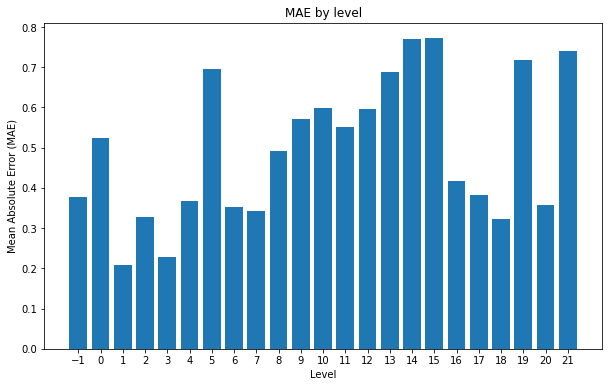

In [124]:
plot_mae_by_level(y_test, y_pred_test)

In [125]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.45
RMSE: 0.67

Round type: round
MSE: 0.45
RMSE: 0.67

Round type: 0.33
MSE: 0.47
RMSE: 0.69

Round type: 0.45
MSE: 0.45
RMSE: 0.67



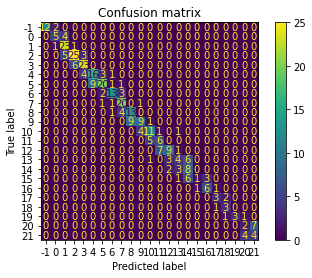

In [126]:
plot_confusion_matrix("round", predict, y_test)

## Random split

In [127]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 8
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[55]	valid_0's l2: 0.243018	valid_0's l1: 0.340495


In [128]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [129]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.24
RMSE: 0.49
MAE: 0.34


In [130]:
results.loc[2] = ["random", "normal", len(X_test.columns), mse, rmse, mae]

###### MAE by level

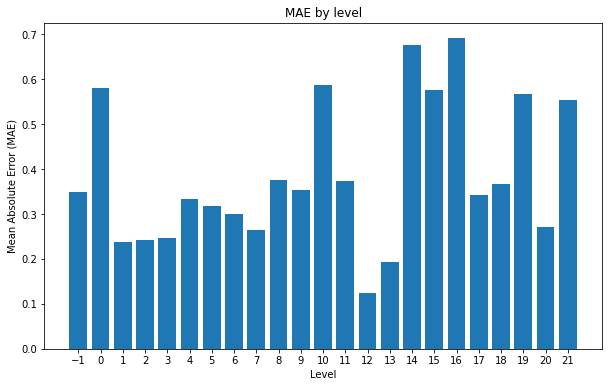

In [131]:
plot_mae_by_level(y_test_random_split, y_pred_test)

In [132]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 0.24
RMSE: 0.49

Round type: round
MSE: 0.26
RMSE: 0.51

Round type: 0.33
MSE: 0.32
RMSE: 0.57

Round type: 0.45
MSE: 0.27
RMSE: 0.52



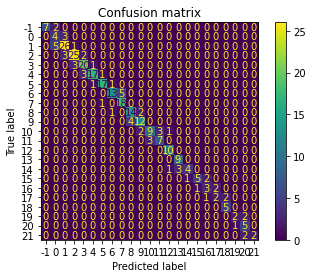

In [133]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

### Tuning

In [134]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-04 13:54:32,053] A new study created in memory with name: no-name-24b80504-9109-45be-a712-a774fc50fb67
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.309343 + 0.0541712
[200]	cv_agg's l2: 0.292654 + 0.0524236
[300]	cv_agg's l2: 0.291959 + 0.0528952


feature_fraction, val_score: 0.290914:  14%|######4                                      | 1/7 [00:03<00:20,  3.43s/it]

Early stopping, best iteration is:
[233]	cv_agg's l2: 0.290914 + 0.0521915
[100]	cv_agg's l2: 0.258517 + 0.0415643
[200]	cv_agg's l2: 0.256276 + 0.0389015


feature_fraction, val_score: 0.255669:  29%|############8                                | 2/7 [00:06<00:17,  3.48s/it]

Early stopping, best iteration is:
[177]	cv_agg's l2: 0.255669 + 0.0385289
[100]	cv_agg's l2: 0.251205 + 0.0454382


feature_fraction, val_score: 0.250202:  43%|###################2                         | 3/7 [00:08<00:11,  2.80s/it]

[200]	cv_agg's l2: 0.252873 + 0.040655
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.250202 + 0.045333
[100]	cv_agg's l2: 0.251205 + 0.0454382


feature_fraction, val_score: 0.250202:  57%|#########################7                   | 4/7 [00:10<00:07,  2.43s/it]

[200]	cv_agg's l2: 0.252873 + 0.040655
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.250202 + 0.045333
[100]	cv_agg's l2: 0.316965 + 0.0456782


feature_fraction, val_score: 0.250202:  71%|################################1            | 5/7 [00:12<00:04,  2.22s/it]

[200]	cv_agg's l2: 0.294239 + 0.0452928
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.250202 + 0.045333
[100]	cv_agg's l2: 0.256328 + 0.0777765


feature_fraction, val_score: 0.250202:  86%|######################################5      | 6/7 [00:14<00:02,  2.17s/it]

[200]	cv_agg's l2: 0.259774 + 0.07799
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.250202 + 0.045333
[100]	cv_agg's l2: 0.244999 + 0.0550316


feature_fraction, val_score: 0.243159: 100%|#############################################| 7/7 [00:16<00:00,  2.36s/it]


Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024


num_leaves, val_score: 0.243159:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.244999 + 0.0550316


num_leaves, val_score: 0.243159:   5%|##5                                               | 1/20 [00:01<00:33,  1.77s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244999 + 0.0550316


num_leaves, val_score: 0.243159:  10%|#####                                             | 2/20 [00:03<00:32,  1.80s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244999 + 0.0550316


num_leaves, val_score: 0.243159:  15%|#######5                                          | 3/20 [00:05<00:31,  1.85s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.247664 + 0.0624908


num_leaves, val_score: 0.243159:  20%|##########                                        | 4/20 [00:06<00:22,  1.41s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244999 + 0.0550316


num_leaves, val_score: 0.243159:  25%|############5                                     | 5/20 [00:08<00:24,  1.60s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244999 + 0.0550316


num_leaves, val_score: 0.243159:  30%|###############                                   | 6/20 [00:10<00:24,  1.78s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.251474 + 0.0695295


num_leaves, val_score: 0.243159:  35%|#################5                                | 7/20 [00:11<00:22,  1.70s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244999 + 0.0550316


num_leaves, val_score: 0.243159:  40%|####################                              | 8/20 [00:13<00:20,  1.72s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244999 + 0.0550316


num_leaves, val_score: 0.243159:  45%|######################5                           | 9/20 [00:15<00:19,  1.75s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244999 + 0.0550316


num_leaves, val_score: 0.243159:  50%|########################5                        | 10/20 [00:17<00:17,  1.75s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244999 + 0.0550316


num_leaves, val_score: 0.243159:  55%|##########################9                      | 11/20 [00:19<00:17,  1.90s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244999 + 0.0550316


num_leaves, val_score: 0.243159:  60%|#############################4                   | 12/20 [00:21<00:15,  1.99s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244999 + 0.0550316


num_leaves, val_score: 0.243159:  65%|###############################8                 | 13/20 [00:25<00:17,  2.49s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244999 + 0.0550316


num_leaves, val_score: 0.243159:  70%|##################################3              | 14/20 [00:33<00:24,  4.16s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244999 + 0.0550316


num_leaves, val_score: 0.243159:  75%|####################################7            | 15/20 [00:36<00:19,  3.86s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244999 + 0.0550316


num_leaves, val_score: 0.243159:  80%|#######################################2         | 16/20 [00:39<00:14,  3.72s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244999 + 0.0550316


num_leaves, val_score: 0.243159:  85%|#########################################6       | 17/20 [00:42<00:10,  3.42s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244999 + 0.0550316


num_leaves, val_score: 0.243159:  90%|############################################1    | 18/20 [00:44<00:06,  3.03s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244999 + 0.0550316


num_leaves, val_score: 0.243159:  95%|##############################################5  | 19/20 [00:46<00:02,  2.78s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244999 + 0.0550316


num_leaves, val_score: 0.243159: 100%|#################################################| 20/20 [00:49<00:00,  2.47s/it]


Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024


bagging, val_score: 0.243159:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.265366 + 0.0530443


bagging, val_score: 0.243159:  10%|#####3                                               | 1/10 [00:01<00:13,  1.55s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.246576 + 0.0573358


bagging, val_score: 0.243159:  20%|##########6                                          | 2/10 [00:03<00:14,  1.82s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.300812 + 0.04613


bagging, val_score: 0.243159:  30%|###############9                                     | 3/10 [00:04<00:10,  1.49s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.246509 + 0.0530728


bagging, val_score: 0.243159:  40%|#####################2                               | 4/10 [00:06<00:09,  1.58s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.299159 + 0.0541563


bagging, val_score: 0.243159:  50%|##########################5                          | 5/10 [00:07<00:06,  1.36s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.252664 + 0.0569201


bagging, val_score: 0.243159:  60%|###############################8                     | 6/10 [00:08<00:05,  1.37s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.271006 + 0.043214


bagging, val_score: 0.243159:  70%|#####################################                | 7/10 [00:10<00:04,  1.33s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.252096 + 0.0521358


bagging, val_score: 0.243159:  80%|##########################################4          | 8/10 [00:11<00:02,  1.38s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.272085 + 0.0357044


bagging, val_score: 0.243159:  90%|###############################################7     | 9/10 [00:12<00:01,  1.31s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.246147 + 0.0474578


bagging, val_score: 0.243159: 100%|####################################################| 10/10 [00:14<00:00,  1.42s/it]


Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024


feature_fraction_stage2, val_score: 0.243159:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.244999 + 0.0550316


feature_fraction_stage2, val_score: 0.243159:  17%|######3                               | 1/6 [00:01<00:07,  1.59s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.256328 + 0.0777765


feature_fraction_stage2, val_score: 0.243159:  33%|############6                         | 2/6 [00:03<00:06,  1.64s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.256328 + 0.0777765


feature_fraction_stage2, val_score: 0.243159:  50%|###################                   | 3/6 [00:05<00:05,  1.79s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244999 + 0.0550316


feature_fraction_stage2, val_score: 0.243159:  67%|#########################3            | 4/6 [00:06<00:03,  1.75s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244999 + 0.0550316


feature_fraction_stage2, val_score: 0.243159:  83%|###############################6      | 5/6 [00:09<00:02,  2.13s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244999 + 0.0550316


feature_fraction_stage2, val_score: 0.243159: 100%|######################################| 6/6 [00:11<00:00,  1.93s/it]


Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024


regularization_factors, val_score: 0.243159:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.244222 + 0.0555085


regularization_factors, val_score: 0.243159:   5%|#9                                    | 1/20 [00:01<00:33,  1.75s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.261688 + 0.0595514


regularization_factors, val_score: 0.243159:  10%|###8                                  | 2/20 [00:02<00:21,  1.19s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.246379 + 0.0576656


regularization_factors, val_score: 0.243159:  15%|#####7                                | 3/20 [00:04<00:26,  1.55s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.250133 + 0.0603374


regularization_factors, val_score: 0.243159:  20%|#######6                              | 4/20 [00:05<00:22,  1.40s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.246379 + 0.0576656


regularization_factors, val_score: 0.243159:  25%|#########5                            | 5/20 [00:07<00:23,  1.57s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.24547 + 0.0566454


regularization_factors, val_score: 0.243159:  30%|###########4                          | 6/20 [00:09<00:24,  1.74s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.246379 + 0.0576656


regularization_factors, val_score: 0.243159:  35%|#############3                        | 7/20 [00:11<00:23,  1.80s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.244121 + 0.0586632


regularization_factors, val_score: 0.243159:  40%|###############2                      | 8/20 [00:13<00:21,  1.82s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.243159 + 0.0562024
[100]	cv_agg's l2: 0.24324 + 0.0580463
[200]	cv_agg's l2: 0.244381 + 0.0545922


regularization_factors, val_score: 0.242825:  45%|#################1                    | 9/20 [00:15<00:21,  1.95s/it]

Early stopping, best iteration is:
[144]	cv_agg's l2: 0.242825 + 0.0562199
[100]	cv_agg's l2: 0.247986 + 0.0610599
[200]	cv_agg's l2: 0.24996 + 0.0564242


regularization_factors, val_score: 0.242825:  50%|##################5                  | 10/20 [00:17<00:20,  2.03s/it]

Early stopping, best iteration is:
[144]	cv_agg's l2: 0.242825 + 0.0562199
[100]	cv_agg's l2: 0.247849 + 0.0631854
[200]	cv_agg's l2: 0.24901 + 0.0566592


regularization_factors, val_score: 0.242825:  55%|####################3                | 11/20 [00:20<00:18,  2.09s/it]

Early stopping, best iteration is:
[144]	cv_agg's l2: 0.242825 + 0.0562199
[100]	cv_agg's l2: 0.243163 + 0.0541657


regularization_factors, val_score: 0.242738:  60%|######################2              | 12/20 [00:21<00:15,  1.99s/it]

Early stopping, best iteration is:
[90]	cv_agg's l2: 0.242738 + 0.053783
[100]	cv_agg's l2: 0.243995 + 0.0536878


regularization_factors, val_score: 0.242738:  65%|########################             | 13/20 [00:23<00:13,  1.98s/it]

Early stopping, best iteration is:
[90]	cv_agg's l2: 0.242738 + 0.053783
[100]	cv_agg's l2: 0.246225 + 0.0612027


regularization_factors, val_score: 0.242738:  70%|#########################9           | 14/20 [00:25<00:11,  1.92s/it]

Early stopping, best iteration is:
[90]	cv_agg's l2: 0.242738 + 0.053783
[100]	cv_agg's l2: 0.246379 + 0.0576656


regularization_factors, val_score: 0.242738:  75%|###########################7         | 15/20 [00:27<00:09,  1.89s/it]

Early stopping, best iteration is:
[90]	cv_agg's l2: 0.242738 + 0.053783
[100]	cv_agg's l2: 0.248623 + 0.0570343


regularization_factors, val_score: 0.242738:  80%|#############################6       | 16/20 [00:29<00:07,  1.84s/it]

Early stopping, best iteration is:
[90]	cv_agg's l2: 0.242738 + 0.053783
[100]	cv_agg's l2: 0.246379 + 0.0576656


regularization_factors, val_score: 0.242738:  85%|###############################4     | 17/20 [00:30<00:05,  1.82s/it]

Early stopping, best iteration is:
[90]	cv_agg's l2: 0.242738 + 0.053783
[100]	cv_agg's l2: 0.244252 + 0.0573433


regularization_factors, val_score: 0.242738:  90%|#################################3   | 18/20 [00:32<00:03,  1.78s/it]

Early stopping, best iteration is:
[90]	cv_agg's l2: 0.242738 + 0.053783
[100]	cv_agg's l2: 0.248767 + 0.0601831


regularization_factors, val_score: 0.242738:  95%|###################################1 | 19/20 [00:34<00:01,  1.75s/it]

Early stopping, best iteration is:
[90]	cv_agg's l2: 0.242738 + 0.053783
[100]	cv_agg's l2: 0.24576 + 0.0595864


regularization_factors, val_score: 0.242738: 100%|#####################################| 20/20 [00:36<00:00,  1.80s/it]


Early stopping, best iteration is:
[90]	cv_agg's l2: 0.242738 + 0.053783


min_data_in_leaf, val_score: 0.242738:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.333162 + 0.0822044


min_data_in_leaf, val_score: 0.242738:  20%|#########                                    | 1/5 [00:00<00:03,  1.24it/s]

Early stopping, best iteration is:
[90]	cv_agg's l2: 0.242738 + 0.053783
[100]	cv_agg's l2: 0.259966 + 0.0580704


min_data_in_leaf, val_score: 0.242738:  40%|##################                           | 2/5 [00:02<00:03,  1.27s/it]

Early stopping, best iteration is:
[90]	cv_agg's l2: 0.242738 + 0.053783
[100]	cv_agg's l2: 0.247969 + 0.059473


min_data_in_leaf, val_score: 0.242738:  60%|###########################                  | 3/5 [00:04<00:03,  1.76s/it]

Early stopping, best iteration is:
[90]	cv_agg's l2: 0.242738 + 0.053783
[100]	cv_agg's l2: 0.249238 + 0.0633624


min_data_in_leaf, val_score: 0.242738:  80%|####################################         | 4/5 [00:06<00:01,  1.87s/it]

Early stopping, best iteration is:
[90]	cv_agg's l2: 0.242738 + 0.053783
[100]	cv_agg's l2: 0.822419 + 0.0698047


min_data_in_leaf, val_score: 0.242738: 100%|#############################################| 5/5 [00:07<00:00,  1.46s/it]

Early stopping, best iteration is:
[90]	cv_agg's l2: 0.242738 + 0.053783


In [135]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.24273826765530018
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.00020004003307818222
    lambda_l2: 1.7475134773659435e-08
    num_leaves: 31
    feature_fraction: 0.8999999999999999
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20


In [136]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [137]:
rmse, mse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.53
MSE test: 0.28
MAE test: 0.35



In [138]:
results.loc[3] = ["random", "Optuna", len(X_test.columns), mse, rmse, mae]

###### MAE by level

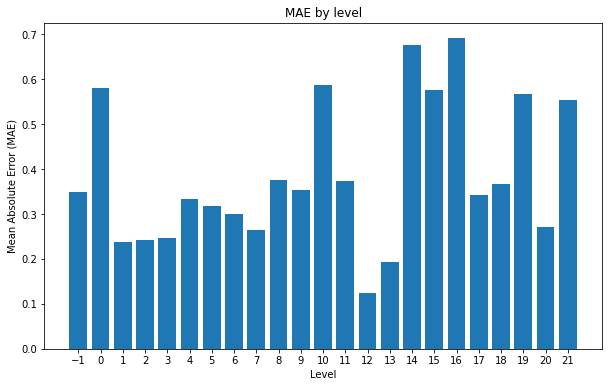

In [139]:
plot_mae_by_level(y_test_random_split, y_pred_test)

In [140]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.13
RMSE: 0.36

Round type: round
MSE: 0.14
RMSE: 0.38

Round type: 0.33
MSE: 0.15
RMSE: 0.39

Round type: 0.45
MSE: 0.14
RMSE: 0.38



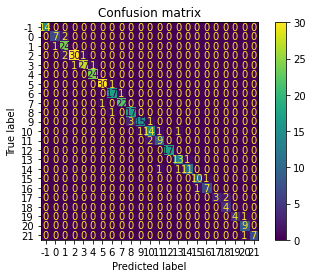

In [141]:
plot_confusion_matrix("round", predict, y_test)

## Summary

In [142]:
results

,Split type,Tuning type,Number of characteristics,MSE,RMSE,MAE
0,chronological,normal,8,0.447566,0.669004,0.467604
1,chronological,Optuna,8,0.447064,0.668629,0.481825
2,random,normal,8,0.243018,0.492968,0.340495
3,random,Optuna,8,0.277484,0.526768,0.346474


In [143]:
from training.results import plot_summary

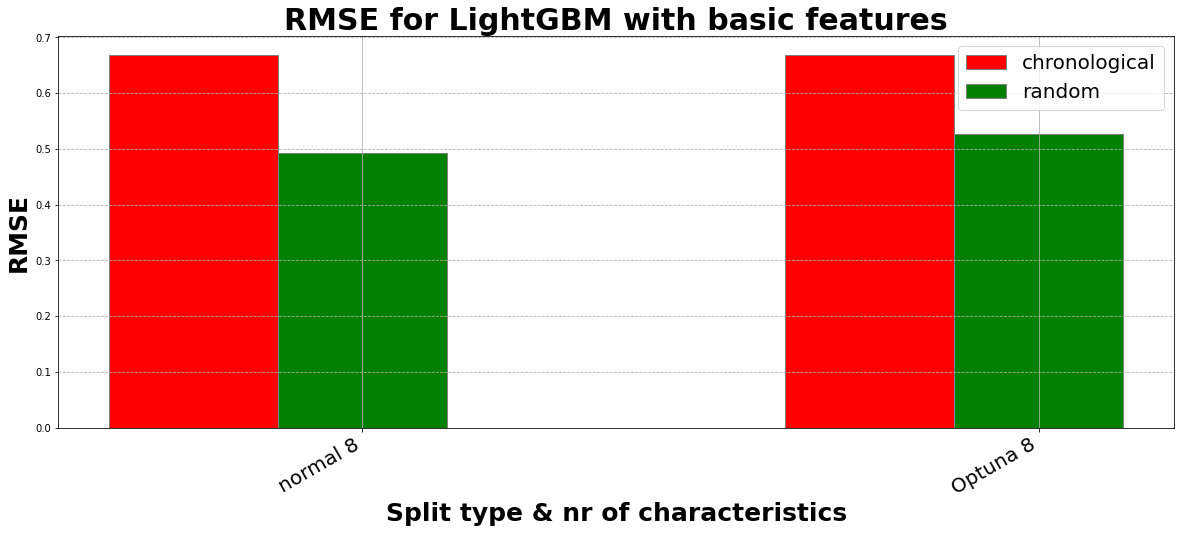

In [144]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with basic features")

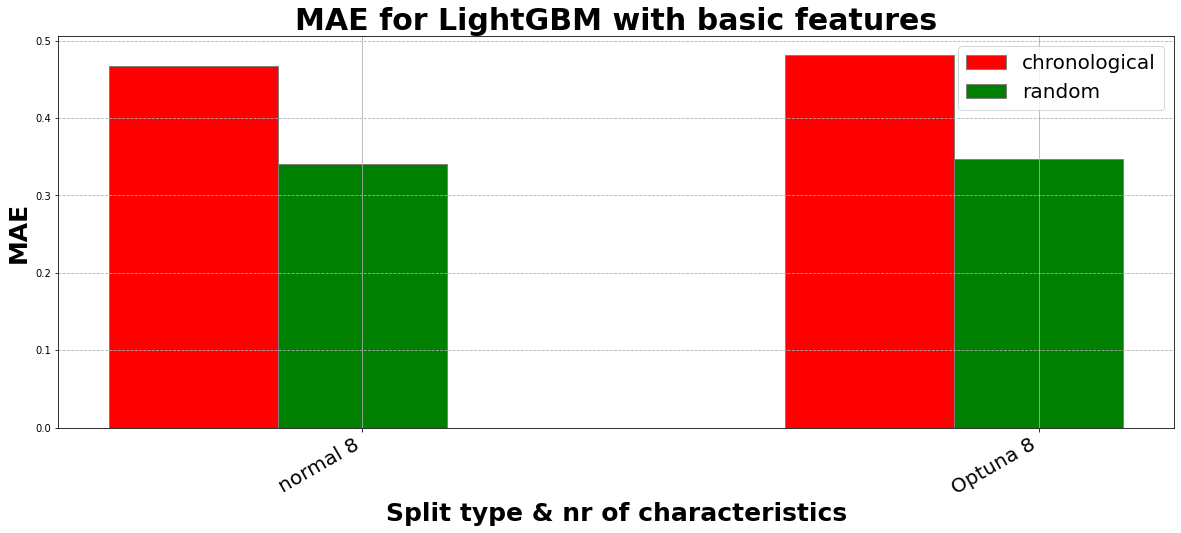

In [145]:
plot_summary(results, "MAE", title="MAE for LightGBM with basic features")

In [146]:
results.to_json("./lightgbm_basic_results.json")